# TIME SERIES FORCASTING USING ENSEMBLE APPROCAH
In this project, I applied 6 different time series forcasting model to daily bike sharing dataset and adopted the average of the forcasts from the different model as the actual forcast. The 5 theoretical model used are Winter-Holt, Tbats, TF Probability, SARIMAX, Facebook Prophet, Facebook Prophet plus XGBoost. The dataset has holidays taken into consideration as well as external regressor, hence forcasting into the future will request prior knowldge of fixing of the external regressors. Technologies used in this project are:
 - Pnadas
 - Numpy
 - statsmodel
 - tbats
 - tensorflow_probability
 - pmdarima
 - fbprophet
 - xgboost

In [21]:
#import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [22]:
#get the data
data = pd.read_csv("../data/Daily Bike Sharing.csv", 
                   index_col = "dteday", 
                   parse_dates = True)
data.head(1)

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [23]:
#select variables
dataset = data.loc[:, ["cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head(1)  

,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [24]:
#renaming variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset.head(1)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [25]:
#index
dataset = dataset.asfreq("D")
dataset.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq='D')

<AxesSubplot: xlabel='dteday'>

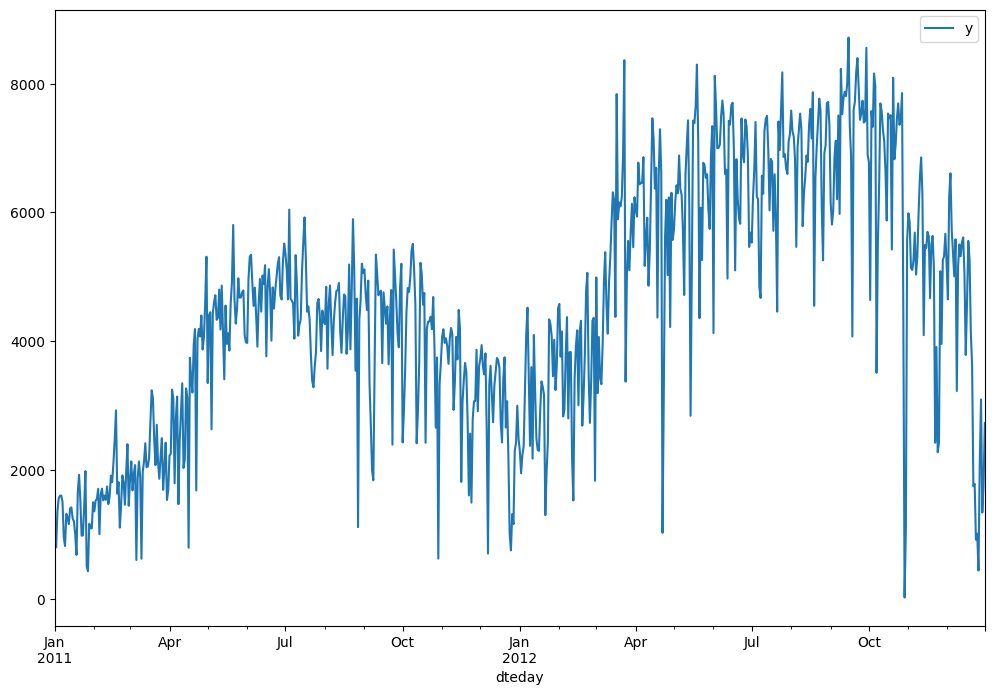

In [26]:
#viz
dataset["y"].plot(figsize = (12, 8), legend = True)

# MODEL DECOMPOSITION

In [27]:
#library
from statsmodels.tsa.seasonal import seasonal_decompose

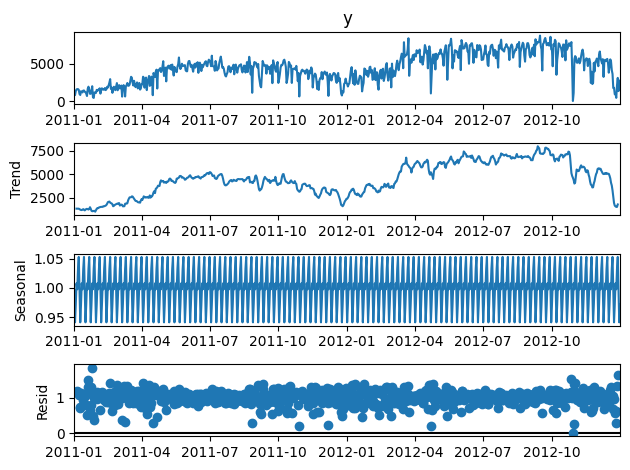

In [28]:
decomposition = seasonal_decompose(x=dataset.y,
    model='multiplicative',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
)
decomposition.plot();

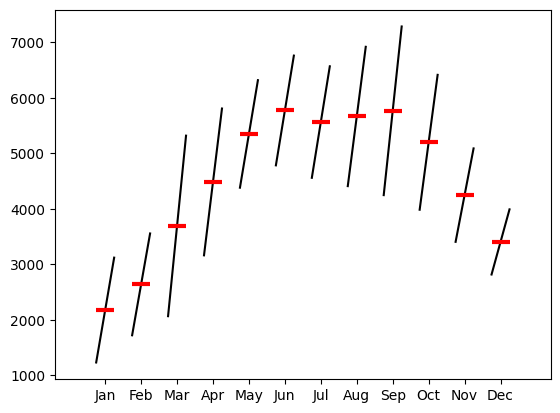

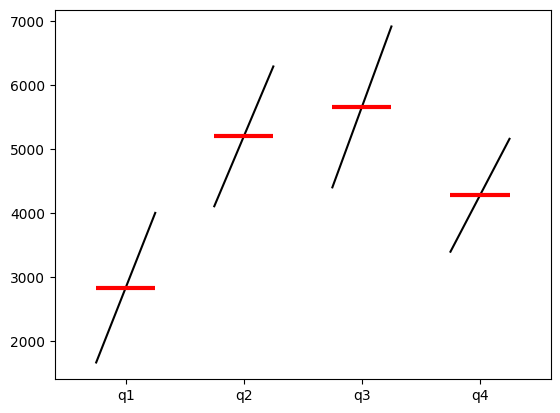

In [29]:
#seasonality graphs
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
month_plot(dataset.y.resample(rule = 'MS').mean())
quarter_plot(dataset.y.resample(rule = 'Q').mean());

# WINTER-HOLT

In [30]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2012-12-31,2729,0,1,2,0.215833,0.223487,0.5775,0.154846


In [31]:
#libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [32]:
#forecasting model
model = ExponentialSmoothing(endog = training_set.y,
                             trend = 'mul',
                             seasonal = 'mul',
                             seasonal_periods = 7).fit()

In [33]:
#predictions
predictions_hw = model.forecast(steps = len(test_set)).rename("HW")
predictions_hw.head()

2012-12-01    4676.804684
2012-12-02    4153.246795
2012-12-03    4322.003783
2012-12-04    4279.673415
2012-12-05    4825.991667
Freq: D, Name: HW, dtype: float64

<AxesSubplot: xlabel='dteday'>

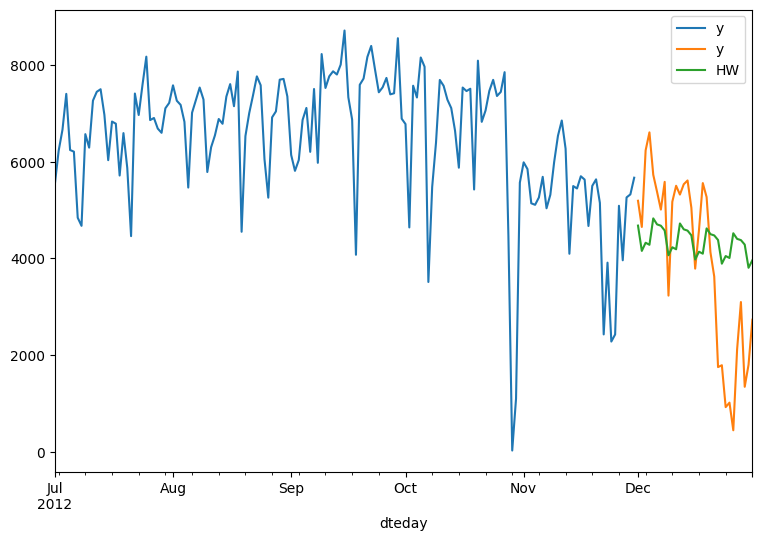

In [34]:
#visualization
training_set['y']['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True)
predictions_hw.plot(legend = True)

### MODEL ASSESSMENT

In [35]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_hw),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_hw)), 0))

1389.0
1698.0


In [36]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_hw)

87.26099293841784

In [37]:
#save prediction
predictions_hw.to_csv('../data/forcasts/predictions_hw.csv', index = True)

# TBATS MODEL

In [38]:
#libraries
from tbats import TBATS

In [39]:
#tbats model
model = TBATS(seasonal_periods = [7, 365.5])
model = model.fit(training_set['y'])

In [40]:
#predictions
predictions_tbats = pd.Series(model.forecast(steps = len(test_set))).rename("TBATS")
predictions_tbats.index = test_set.index
predictions_tbats.head()

dteday
2012-12-01    4783.665650
2012-12-02    4330.863795
2012-12-03    4249.891170
2012-12-04    4306.164992
2012-12-05    4434.570173
Freq: D, Name: TBATS, dtype: float64

<AxesSubplot: xlabel='dteday'>

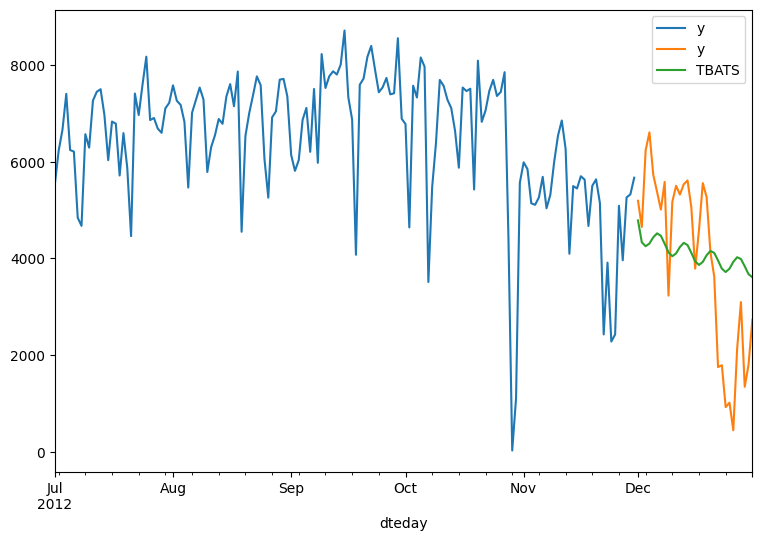

In [41]:
#visualization
training_set['y']['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True)
predictions_tbats.plot(legend = True)

Model Assessment

In [42]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_tbats),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_tbats)), 0))

1371.0
1602.0


In [43]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_tbats)

78.93076308463965

In [44]:
#save prediction
predictions_tbats.to_csv('../data/predictions_tbats.csv', index = True)

# TENSORFLOW PROBABILITY

In [45]:
#index
dataset = dataset.asfreq("D")
dataset.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq='D')

<AxesSubplot: xlabel='dteday'>

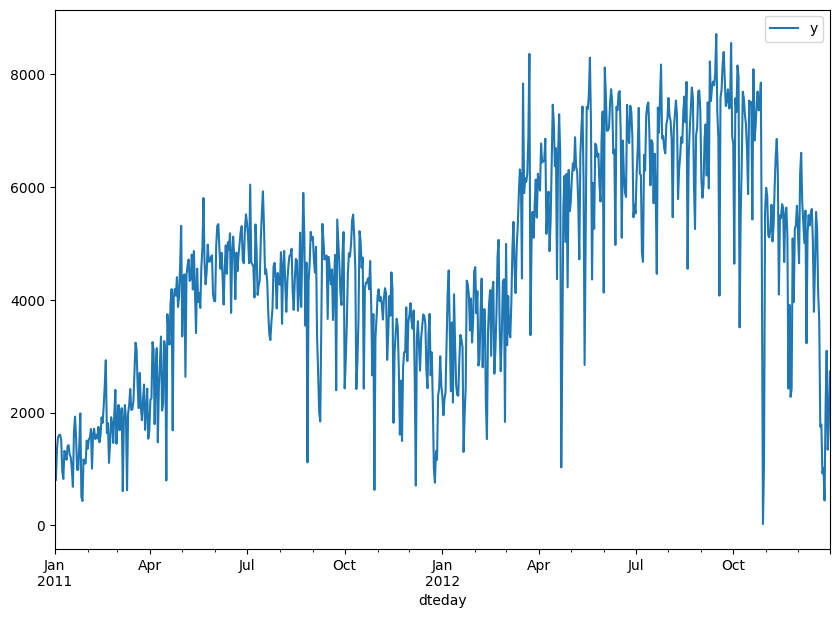

In [46]:
#viz
dataset["y"].plot(figsize = (10, 7), legend = True)

In [47]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2012-12-31,2729,0,1,2,0.215833,0.223487,0.5775,0.154846


In [48]:
#get a library
import tensorflow_probability as tfp

In [49]:
#Isolate the regressors
exog = np.asmatrix(dataset.iloc[:,1:].astype(np.float64))
exog[:1]

matrix([[0.      , 0.      , 2.      , 0.344167, 0.363625, 0.805833,
         0.160446]])

In [50]:
#linear regression
regressors = tfp.sts.LinearRegression(design_matrix = exog,
                                      name = "regressors")

In [51]:
#isolating dependent variable
y = training_set['y'].astype(np.float64)
y[:5]

dteday
2011-01-01     985.0
2011-01-02     801.0
2011-01-03    1349.0
2011-01-04    1562.0
2011-01-05    1600.0
Freq: D, Name: y, dtype: float64

In [52]:
#Weekday seasonality
weekday_effect = tfp.sts.Seasonal(num_seasons = 7,
                                  num_steps_per_season = 1,
                                  observed_time_series = y,
                                  name = "weekday_effect")

In [53]:
#number of days per month
num_days_per_month = np.array(
    [[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], #2011
     [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]) # 2012

In [54]:
#Monthly seasonality
monthly_effect = tfp.sts.Seasonal(num_seasons = 12,
                                  num_steps_per_season = num_days_per_month,
                                  observed_time_series = y,
                                  name = "monthly_effect")

In [55]:
#trend 
trend = tfp.sts.LocalLinearTrend(observed_time_series=y,
                                 name = "trend")

In [56]:
#Autoregressive
autoregressive = tfp.sts.Autoregressive(order = 1,
                                        observed_time_series = y,
                                        name = "autoregressive")

In [57]:
#forecasting model
model = tfp.sts.Sum([regressors,
                     weekday_effect,
                     monthly_effect,
                     autoregressive,
                     trend],
                    observed_time_series = y)

In [58]:
#fit with HMC
samples, kernel_results = tfp.sts.fit_with_hmc(model = model,
                                               observed_time_series = y,
                                               num_results = 100,
                                               num_warmup_steps = 50,
                                               num_leapfrog_steps = 15,
                                               num_variational_steps = 150,
                                               seed = 1502)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [59]:
#forecast
forecast = tfp.sts.forecast(model = model,
                            observed_time_series = y,
                            parameter_samples = samples,
                            num_steps_forecast = len(test_set))

In [60]:
#predictions
predictions_tfp = pd.Series(forecast.mean()[:,0], name = "TFP")
predictions_tfp.index = test_set.index
predictions_tfp[:2]

dteday
2012-12-01    4241.868945
2012-12-02    3495.131247
Freq: D, Name: TFP, dtype: float64

<AxesSubplot: xlabel='dteday'>

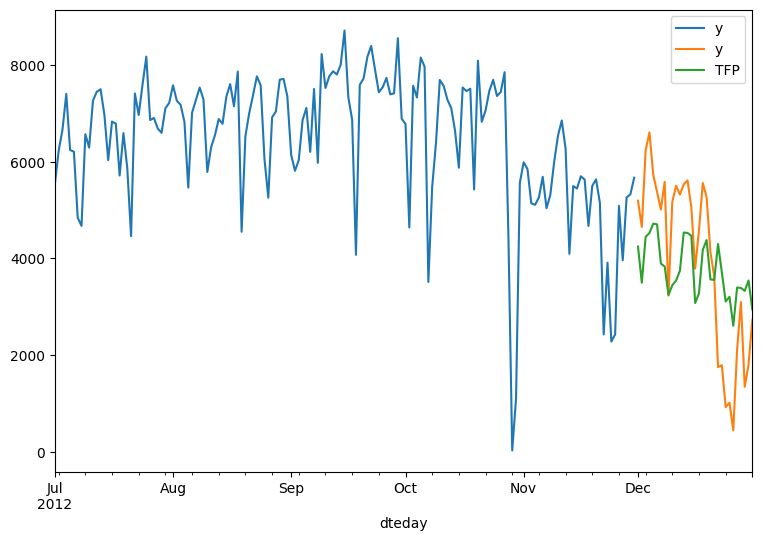

In [61]:
#visualization
training_set['y']['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True)
predictions_tfp.plot(legend = True)

Model Assessment

In [62]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_tfp),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_tfp)), 0))

1288.0
1457.0


In [63]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_tfp)

63.233143939784874

In [64]:
#save prediction
predictions_tfp.to_csv('../data/forcasts/predictions_tfp.csv', index = True)

# SARIMAX

In [65]:
#Libraries
from pmdarima import auto_arima

In [66]:
#get the data
data = pd.read_csv("../data/Daily Bike Sharing.csv", 
                   index_col = "dteday", 
                   parse_dates = True)
data.head(1)

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [67]:
#select variables
dataset = data.loc[:, ["cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head(1) 

,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [68]:
#renaming variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset.head(1)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [69]:
#index
dataset = dataset.asfreq("D")
dataset.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq='D')

<AxesSubplot: xlabel='dteday'>

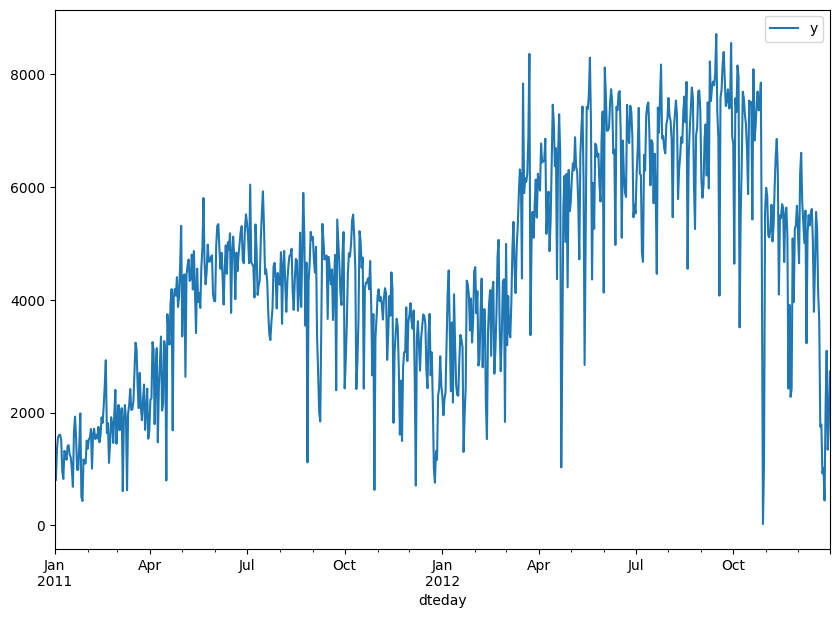

In [70]:
#viz
dataset["y"].plot(figsize = (10, 7), legend = True)

In [71]:
#Stationarity
from statsmodels.tsa.stattools import adfuller
stationarity = adfuller(dataset['y'])
print('Augmented Dickey Fuller p-value: %F' % stationarity[1])

Augmented Dickey Fuller p-value: 0.342743


In [72]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2012-12-31,2729,0,1,2,0.215833,0.223487,0.5775,0.154846


In [73]:
#exogenous variables
train_exog = training_set.iloc[:,1:]
test_exog = test_set.iloc[:,1:]
test_exog.head()

,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,
2012-12-01,0,0,2,0.298333,0.316904,0.806667,0.059704
2012-12-02,0,0,2,0.347500,0.359208,0.823333,0.124379
2012-12-03,0,1,1,0.452500,0.455796,0.767500,0.082721
2012-12-04,0,1,1,0.475833,0.469054,0.733750,0.174129
2012-12-05,0,1,1,0.438333,0.428012,0.485000,0.324021


In [74]:
#forecasting model
model = auto_arima(y = training_set['y'],
                   X = train_exog,
                   m = 7,
                   seasonal = True,
                   stepwise = False)

In [75]:
#summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -5596.921
Date:                Thu, 27 Jul 2023   AIC                          11217.842
Time:                        05:29:46   BIC                          11272.438
Sample:                    01-01-2011   HQIC                         11238.948
                         - 11-30-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.3406      5.562      0.780      0.435      -6.560      15.241
holiday     -240.2530    129.091     -1.861      0.063    -493.267      12.761
workingday    89.1909     60.515      1.474      0.141     -29.415     207.797
weathersit  -460.2038     51.296     -8.971      0.000    -560.743    -359.665
temp        3421.6013   1170.394      2.923      0.003    1127.670    5715.532
atemp       1970.5709   1196.979      1.646      0.100    -375.465    4316.607
hum        -2280.4094    198.489    -11.489      0.000   -2669.442   -1891.377
windspeed  -2275.5734    373.324     -6.095      0.000   -3007.276   -1543.871
ma.L1         -0.5546      0.028    -19.645      0.000      -0.610      -0.499
ma.L2         -0.1348      0.039     -3.422      0.001      -0.212      -0.058
ma.L3         -0.1443      0.040     -3.608      0.000      -0.223      -0.066
sigma2      5.262e+05   2.02e+04     26.111      0.000    4.87e+05    5.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               623.73
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
#predictions
predictions_sarimax = pd.Series(model.predict(n_periods= test_days,
                              X = test_exog)).rename("SARIMAX")
predictions_sarimax.index = test_set.index                              
predictions_sarimax

dteday
2012-12-01    4288.838723
2012-12-02    4216.866418
2012-12-03    5448.169663
2012-12-04    5427.430110
2012-12-05    5448.746126
2012-12-06    4779.534137
2012-12-07    4189.727156
2012-12-08    4177.223765
2012-12-09    4075.888917
2012-12-10    4317.488577
2012-12-11    4356.123537
2012-12-12    4524.487470
2012-12-13    5071.374116
2012-12-14    4766.658516
2012-12-15    4953.818764
2012-12-16    4274.582262
2012-12-17    4385.631797
2012-12-18    5195.199496
2012-12-19    4976.433823
2012-12-20    4518.899200
2012-12-21    4149.108885
2012-12-22    4375.125227
2012-12-23    4812.036905
2012-12-24    3892.488340
2012-12-25    3763.450628
2012-12-26    2788.505797
2012-12-27    3614.740796
2012-12-28    4258.644105
2012-12-29    3848.099616
2012-12-30    4399.751047
2012-12-31    4111.094105
Freq: D, Name: SARIMAX, dtype: float64

<AxesSubplot: xlabel='dteday'>

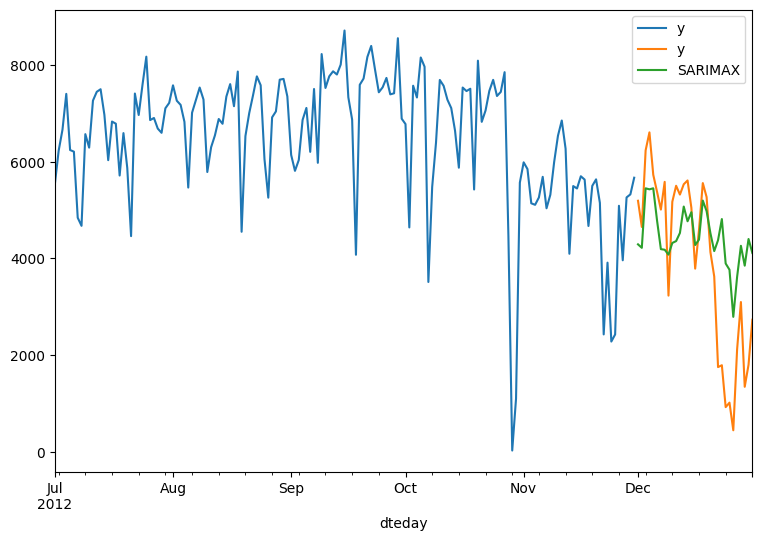

In [77]:
#visualization
training_set['y']['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True)
predictions_sarimax.plot(legend = True)

In [78]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_sarimax),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_sarimax)), 0))

1180.0
1480.0


In [79]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_sarimax)

71.2618228209472

In [80]:
predictions_sarimax.to_csv('../data/forcasts/predictions_sarimax.csv', index = True)

# FACEBOOK PROPHET

In [81]:
#import libraries
import itertools
from fbprophet import Prophet

In [82]:
#get the data
data = pd.read_csv("../data/Daily Bike Sharing.csv")
data.head(1)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [83]:
#select variables
dataset = data.loc[:, ["dteday","cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head(1)  

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,1/1/2011,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [84]:
#Date variable
dataset.dteday = pd.to_datetime(dataset.dteday)
                                #format = "%Y-%m-%d")
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [85]:
#renaming variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset = dataset.rename(columns = {'dteday' : 'ds'})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [86]:
holiday_dates = dataset[dataset.holiday == 1].ds
holidays = pd.DataFrame({'holiday' : 'holi',
                         'ds': pd.to_datetime(holiday_dates),
                         'lower_window': -3,
                         'upper_window': 1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [87]:
#removing holiday column
dataset = dataset.drop(columns = "holiday")
dataset.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


In [88]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846


In [89]:
#Facebook Prophet model
m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

In [90]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future.tail(1)

,ds
730,2012-12-31


In [91]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [92]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,1742.289571,114.195024,1801.319587,1742.289571,1742.289571,-0.041692,-0.041692,-0.041692,-0.303679,...,0.000000,0.000000,0.000000,-0.272471,-0.272471,-0.272471,0.0,0.0,0.0,994.384184
1,2011-01-02,1751.617511,-112.882627,1732.528911,1751.617511,1751.617511,-0.045201,-0.045201,-0.045201,-0.309549,...,0.000000,0.000000,0.000000,-0.264680,-0.264680,-0.264680,0.0,0.0,0.0,815.176347
2,2011-01-03,1760.945452,121.006182,1923.954366,1760.945452,1760.945452,-0.103532,-0.103532,-0.103532,-0.079599,...,0.153287,0.153287,0.153287,-0.255577,-0.255577,-0.255577,0.0,0.0,0.0,1060.833093
3,2011-01-04,1770.273392,226.625291,2093.677758,1770.273392,1770.273392,-0.095468,-0.095468,-0.095468,-0.071153,...,0.153287,0.153287,0.153287,-0.245283,-0.245283,-0.245283,0.0,0.0,0.0,1150.614875
4,2011-01-05,1779.601332,381.594449,2140.768790,1779.601332,1779.601332,-0.089381,-0.089381,-0.089381,0.001644,...,0.153287,0.153287,0.153287,-0.233944,-0.233944,-0.233944,0.0,0.0,0.0,1294.184968


In [93]:
#predictions
predictions_prophet = forecast.yhat[-test_days:].rename("prophet")
predictions_prophet[:5]

700    4178.902807
701    3523.610796
702    5710.341912
703    5708.896390
704    5407.602447
Name: prophet, dtype: float64

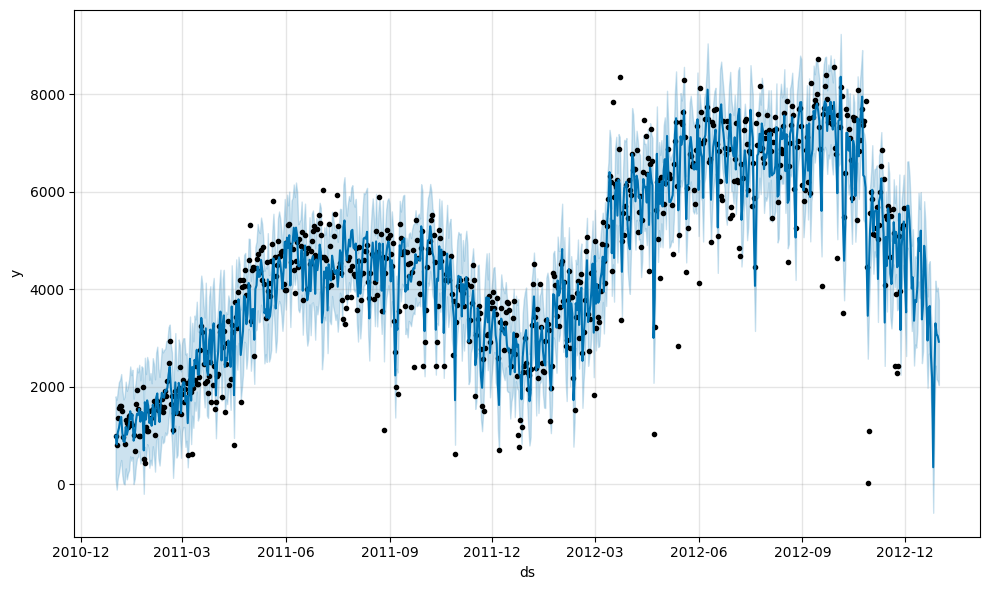

In [94]:
#visualization forecast
m.plot(forecast);

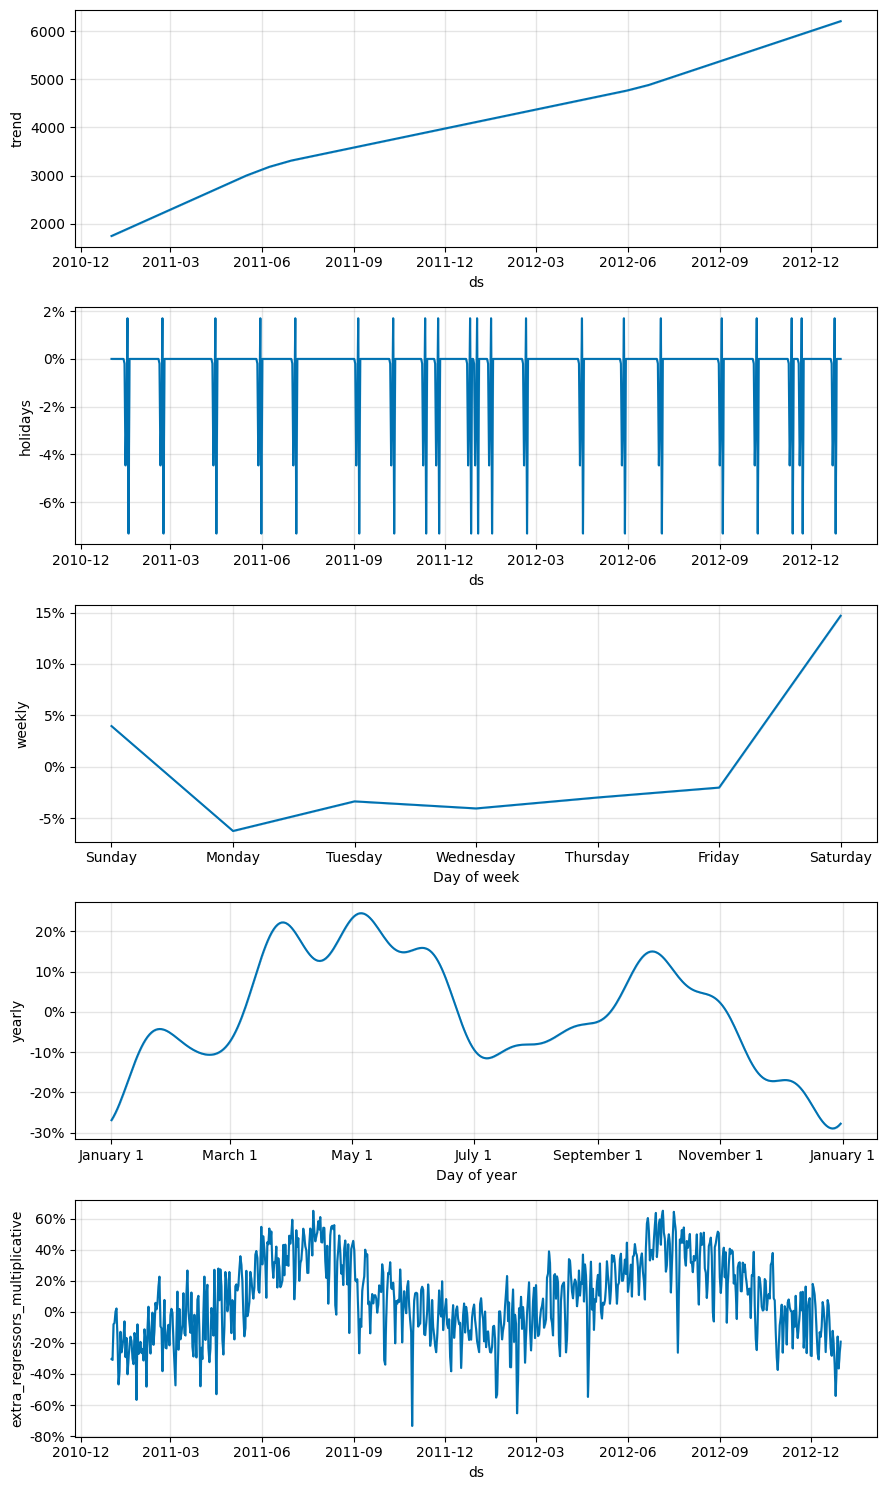

In [95]:
#plot components
m.plot_components(forecast);

Model Assessment

In [96]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)), 0))

855.0
1025.0


In [97]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

34.46651533352936

#### Cross-Validation

In [98]:
#CV
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = "processes")
df_cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B9F8AD2B0>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-29,8167.876475,7415.491222,8915.173584,5463,2012-06-28
1,2012-06-30,7229.866624,6464.577497,7918.331626,5687,2012-06-28
2,2012-07-01,7444.087578,6630.445245,8221.670127,5531,2012-06-28
3,2012-07-02,6775.154217,5991.809015,7536.006050,6227,2012-06-28
4,2012-07-03,7442.887086,6675.048418,8181.075299,6660,2012-06-28


In [99]:
#MAE and RMSE
print(round(mean_absolute_error(df_cv['y'], df_cv['yhat']),0))
print(round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])), 0))
print(MAPE(df_cv['y'], df_cv['yhat']))

1014.0
1274.0
125.38622632488277


#### Hyperparameter

In [100]:
#Parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1],
              'holidays_prior_scale': [5, 10, 20]}
grid = ParameterGrid(param_grid)
list(grid)[:3] 

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20}]

In [101]:
#Hyper parameter tuning
rmse = []
for params in grid:
  #build model
  m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor('workingday')
  m.add_regressor('weathersit')
  m.add_regressor('temp')
  m.add_regressor('atemp')
  m.add_regressor('hum')
  m.add_regressor('windspeed')
  m.fit(training_set)

  #cross-validation
  df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = "processes")
  
  #gather the results
  error = np.sqrt(mean_squared_error(df_cv['y'], 
                                     df_cv['yhat']))
  rmse.append(error)

INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B9F88F850>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B9DB0A2E0>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B9E4FC5B0>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B9E514280>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in pa

In [102]:
#best parameters
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 10, 'holidays_prior_scale': 20, 'changepoint_prior_scale': 0.01}


### Final Prophet Model

In [103]:
#build model
m = Prophet(growth = "linear",
          yearly_seasonality = True,
          weekly_seasonality = True,
          daily_seasonality = False,
          holidays = holidays,
          seasonality_mode = "multiplicative",
          seasonality_prior_scale = best_params['seasonality_prior_scale'],
          holidays_prior_scale = best_params['holidays_prior_scale'],
          changepoint_prior_scale = best_params['changepoint_prior_scale'])
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

In [104]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail(1)

,ds,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,1,2,0.215833,0.223487,0.5775,0.154846


In [105]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2460.565877,346.104659,2166.180952,2460.565877,2460.565877,-0.056276,-0.056276,-0.056276,-0.280592,...,0.000000,0.000000,0.000000,-0.263772,-0.263772,-0.263772,0.0,0.0,0.0,1246.477003
1,2011-01-02,2466.147889,35.874991,1926.753841,2466.147889,2466.147889,-0.061013,-0.061013,-0.061013,-0.288996,...,0.000000,0.000000,0.000000,-0.257070,-0.257070,-0.257070,0.0,0.0,0.0,1002.285416
2,2011-01-03,2471.729900,339.120211,2218.313936,2471.729900,2471.729900,-0.139749,-0.139749,-0.139749,-0.201514,...,0.023045,0.023045,0.023045,-0.249073,-0.249073,-0.249073,0.0,0.0,0.0,1295.306197
3,2011-01-04,2477.311912,561.899979,2362.137310,2477.311912,2477.311912,-0.128865,-0.128865,-0.128865,-0.191456,...,0.023045,0.023045,0.023045,-0.239905,-0.239905,-0.239905,0.0,0.0,0.0,1413.160884
4,2011-01-05,2482.893923,673.067431,2577.220366,2482.893923,2482.893923,-0.120649,-0.120649,-0.120649,-0.124144,...,0.023045,0.023045,0.023045,-0.229707,-0.229707,-0.229707,0.0,0.0,0.0,1599.283251


In [106]:
#extract predictions
predictions_prophet_tuned = forecast.yhat[-test_days:].rename("prophet_tuned")
predictions_prophet_tuned.index = test_set["ds"]
predictions_prophet_tuned.head()

ds
2012-12-01    4123.271602
2012-12-02    3497.495660
2012-12-03    5606.009076
2012-12-04    5602.273010
2012-12-05    5316.511584
Name: prophet_tuned, dtype: float64

In [107]:
# Save Prediction
predictions_prophet_tuned.to_csv('../data/forcasts/predictions_prophet_tuned.csv', index = True)

# FACEBOOK PROPHET + XGBOOST

In [108]:
#import libraries
import xgboost as xgb
from fbprophet import Prophet

In [109]:
#get the data
data = pd.read_csv("../data/Daily Bike Sharing.csv")
data.head(1)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [110]:
#select variables
dataset = data.loc[:, ["dteday","cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head(1) 

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,1/1/2011,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [111]:
#Date variable
dataset.dteday = pd.to_datetime(dataset.dteday)
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [112]:
#renaming variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset = dataset.rename(columns = {'dteday' : 'ds'})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [113]:
holiday_dates = dataset[dataset.holiday == 1].ds
holidays = pd.DataFrame({'holiday' : 'holi',
                         'ds': pd.to_datetime(holiday_dates),
                         'lower_window': -3,
                         'upper_window': 1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [114]:
#removing holiday column
dataset = dataset.drop(columns = "holiday")
dataset.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


In [115]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846


In [116]:
#Facebook Prophet model
m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 20,
            holidays_prior_scale = 20,
            changepoint_prior_scale = 0.01)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

In [117]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future.tail(1)

,ds
730,2012-12-31


In [118]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [119]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2487.046800,344.992967,2173.929116,2487.046800,2487.046800,-0.055076,-0.055076,-0.055076,-0.283309,...,0.00000,0.00000,0.00000,-0.259582,-0.259582,-0.259582,0.0,0.0,0.0,1270.581025
1,2011-01-02,2492.442494,83.170228,1930.870491,2492.442494,2492.442494,-0.059712,-0.059712,-0.059712,-0.291002,...,0.00000,0.00000,0.00000,-0.253060,-0.253060,-0.253060,0.0,0.0,0.0,1020.101173
2,2011-01-03,2497.838188,382.414630,2209.264452,2497.838188,2497.838188,-0.136769,-0.136769,-0.136769,-0.202226,...,0.02649,0.02649,0.02649,-0.245280,-0.245280,-0.245280,0.0,0.0,0.0,1316.244028
3,2011-01-04,2503.233882,500.606415,2415.442296,2503.233882,2503.233882,-0.126117,-0.126117,-0.126117,-0.192321,...,0.02649,0.02649,0.02649,-0.236363,-0.236363,-0.236363,0.0,0.0,0.0,1434.184329
4,2011-01-05,2508.629576,630.371495,2593.872693,2508.629576,2508.629576,-0.118076,-0.118076,-0.118076,-0.124916,...,0.02649,0.02649,0.02649,-0.226445,-0.226445,-0.226445,0.0,0.0,0.0,1618.241352


In [120]:
#xgboost prep
prophet_variables = forecast.loc[:, ["trend", "holi", "weekly", "yearly"]]
df_xgb = pd.concat([dataset, prophet_variables], axis = 1)
df_xgb.head()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446,2487.046800,0.0,0.053771,-0.259582
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539,2492.442494,0.0,-0.046661,-0.253060
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309,2497.838188,0.0,-0.025540,-0.245280
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296,2503.233882,0.0,0.001617,-0.236363
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900,2508.629576,0.0,-0.003569,-0.226445


In [121]:
#Training and test set
test_days = 31
training_set = df_xgb.iloc[:-test_days, :]
test_set = df_xgb.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846,6425.763224,0.0,-0.02554,-0.262342


In [122]:
#isolate X and Y
y_train = training_set.y
y_test = test_set.y
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]

In [123]:
#create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

In [124]:
#Set the parameters
parameters = {'learning_rate': 0.1,
              'max_depth': 3,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight': 1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

In [125]:
#XGBoost Model
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100,
                  evals = [(Test, "y")],
                  verbose_eval = 15)

[0]	y-rmse:3891.58894
[15]	y-rmse:1614.33541
[30]	y-rmse:1374.02625
[45]	y-rmse:1255.47315
[60]	y-rmse:1210.39461
[75]	y-rmse:1194.27466
[90]	y-rmse:1184.74689
[99]	y-rmse:1173.99976


In [126]:
#Forecasting
predictions_xgb = pd.Series(model.predict(Test), name = "XGBoost")
predictions_xgb.index = test_set.ds
predictions_xgb[:2]

ds
2012-12-01    3939.741943
2012-12-02    3093.367676
Name: XGBoost, dtype: float32

In [127]:
#set up index
training_set.index = training_set.ds
test_set.index = test_set.ds

<AxesSubplot: xlabel='ds'>

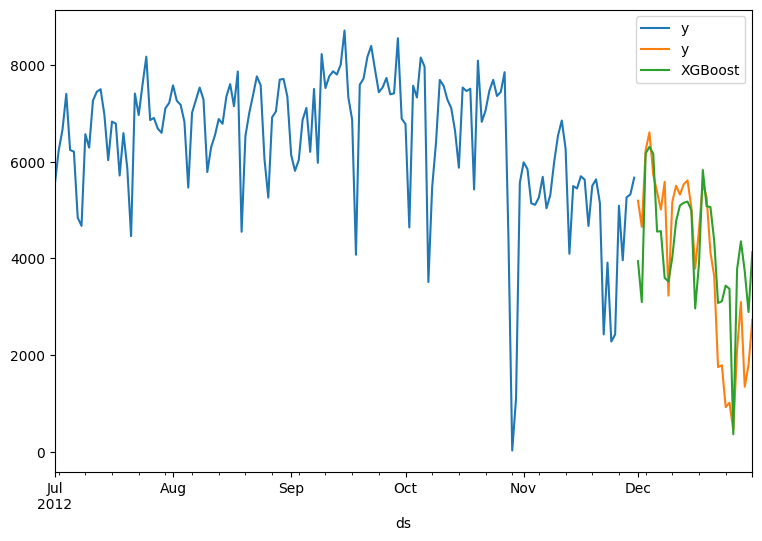

In [128]:
#Viz
training_set.y['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions_xgb.plot(legend = True)

Model Assessment

In [129]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_xgb),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_xgb)), 0))

942.0
1174.0


In [130]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_xgb)

44.11900754437306

In [131]:
predictions_xgb.to_csv('../data/forcasts/predictions_xgb.csv', index = True)

# ENSEMBLE APPROACH

In [132]:
#get the data
data = pd.read_csv("../data/Daily Bike Sharing.csv", 
                   index_col = "dteday", 
                   parse_dates = True)
data.head(1)

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [133]:
#select variables
dataset = data.cnt.rename("y")
dataset.head(1)  

dteday
2011-01-01    985
Name: y, dtype: int64

Data Transformation

In [134]:
#index
dataset = dataset.asfreq("D")
dataset.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq='D')

<AxesSubplot: xlabel='dteday'>

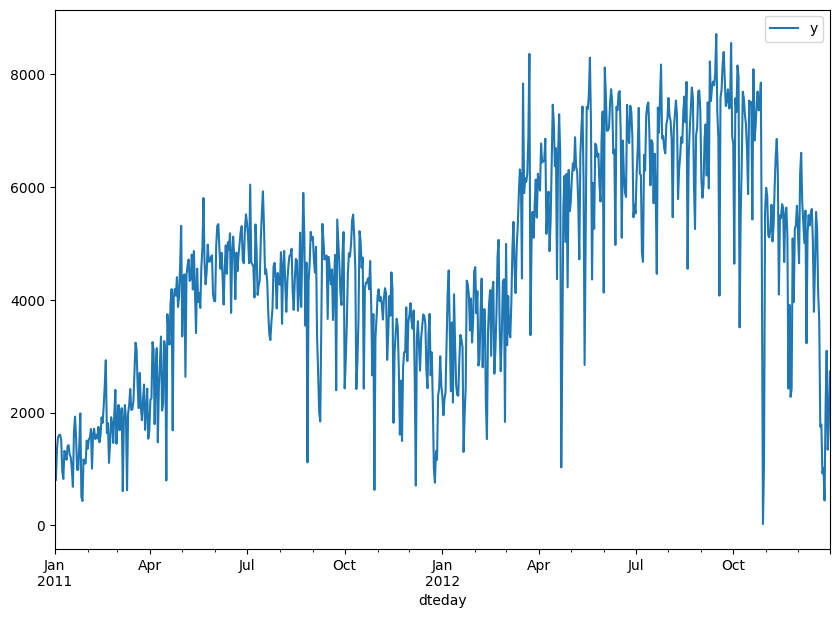

In [135]:
#viz
dataset.plot(figsize = (10, 7), legend = True)

In [136]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days]
test_set = dataset.iloc[-test_days:]
test_set.tail(1)

dteday
2012-12-31    2729
Freq: D, Name: y, dtype: int64

In [137]:
#load predictions
hw = pd.read_csv("../data/forcasts/predictions_hw.csv", index_col= [0], parse_dates=True)
tbats = pd.read_csv("../data/forcasts/predictions_tbats.csv", index_col= [0], parse_dates=True)
sarimax = pd.read_csv("../data/forcasts/predictions_sarimax.csv", index_col= [0], parse_dates=True)
tfp = pd.read_csv("../data/forcasts/predictions_tfp.csv", index_col= [0], parse_dates=True)
prophet_tuned = pd.read_csv("../data/forcasts/predictions_prophet_tuned.csv", index_col= [0], parse_dates=True)
xgboost = pd.read_csv("../data/forcasts/predictions_xgb.csv", index_col= [0], parse_dates=True)

In [138]:
## concatenate predictions
ensemble_df = pd.concat([test_set,hw, tbats, sarimax, tfp, prophet_tuned, xgboost], axis = 1)
ensemble_df.head(20)

,y,HW,TBATS,SARIMAX,TFP,prophet_tuned,XGBoost
2012-12-01,5191,4676.804684,4783.665650,4288.838723,4241.868945,4123.271602,3939.7420
2012-12-02,4649,4153.246795,4330.863795,4216.866418,3495.131247,3497.495660,3093.3677
2012-12-03,6234,4322.003783,4249.891170,5448.169663,4444.178504,5606.009076,6170.7754
2012-12-04,6606,4279.673415,4306.164992,5427.430110,4522.661305,5602.273010,6306.7030
2012-12-05,5729,4825.991667,4434.570173,5448.746126,4717.696177,5316.511584,6162.8037
2012-12-06,5375,4701.723841,4516.006595,4779.534137,4703.057720,4757.804227,4553.7275
2012-12-07,5008,4674.474174,4466.479488,4189.727156,3890.835476,3930.224922,4561.0210
2012-12-08,5582,4575.268886,4300.964588,4177.223765,3830.598093,4153.706787,3592.9194
2012-12-09,3228,4063.077704,4122.148953,4075.888917,3242.043765,3291.632430,3521.2646
2012-12-10,5170,4228.170892,4043.119974,4317.488577,3442.605290,3682.413887,4023.5176


In [143]:
ensemble_df["ensemble"] = ensemble_df.iloc[:,1:].mean(axis = 1)
ensemble_df.tail(20)

,y,HW,TBATS,SARIMAX,TFP,prophet_tuned,XGBoost,ensemble
2012-12-12,5319,4721.216944,4234.205362,4524.487470,3743.205066,3933.383080,5093.5625,4375.010070
2012-12-13,5532,4599.647035,4319.361671,5071.374116,4533.960267,4855.388924,5148.9873,4754.786552
2012-12-14,5611,4572.988973,4273.695661,4766.658516,4525.227306,4604.108813,5173.9010,4652.763378
2012-12-15,5047,4475.937481,4112.182154,4953.818764,4465.471441,4997.182127,4994.2900,4666.480328
2012-12-16,3786,3974.866229,3937.505833,4274.582262,3074.411720,3240.757057,2962.2610,3577.397350
2012-12-17,4585,4136.375160,3862.751571,4385.631797,3275.013981,3514.629093,3885.7188,3843.353400
2012-12-18,5557,4095.862867,3926.262895,5195.199496,4175.754793,4665.383159,5827.1740,4647.606202
2012-12-19,5267,4618.716933,4062.781873,4976.433823,4378.002333,4359.734820,5075.3720,4578.506963
2012-12-20,4128,4499.786368,4152.602682,4518.899200,3563.457730,3582.290371,5061.6973,4229.788942
2012-12-21,3623,4473.707066,4111.725188,4149.108885,3553.913497,2743.533886,4358.0490,3898.339587


<AxesSubplot: >

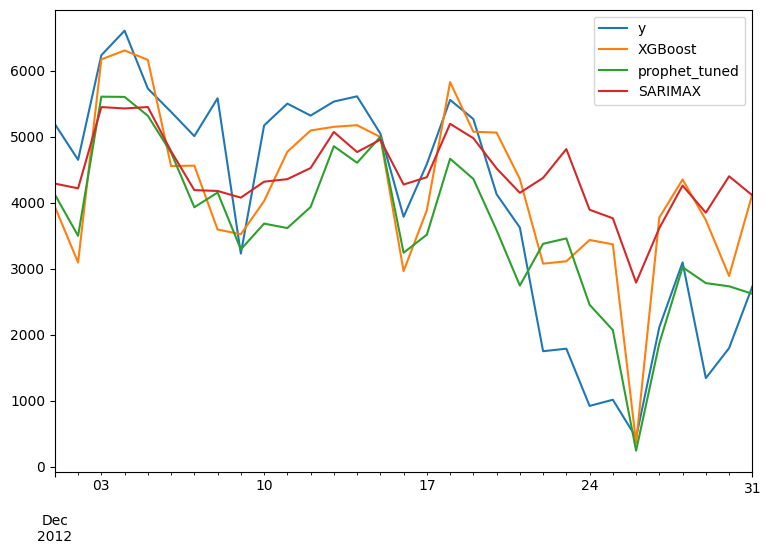

In [144]:
#visualization
ensemble_df.y.plot(figsize = (9,6), legend = True)
ensemble_df.XGBoost.plot(legend  = True)
ensemble_df.prophet_tuned.plot(legend = True)
ensemble_df.SARIMAX.plot(legend = True)

<AxesSubplot: >

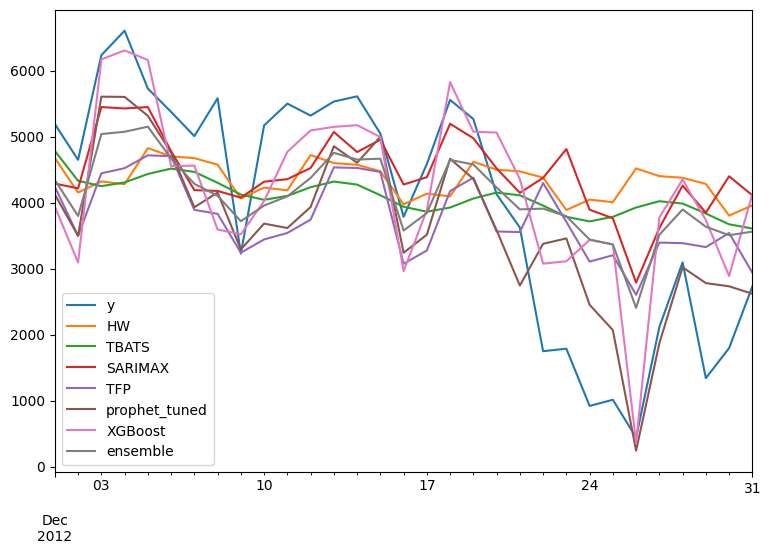

In [145]:
ensemble_df.plot(figsize = (9,6), legend = True)

Model Assessment

In [146]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(ensemble_df.y, ensemble_df.ensemble),0))
print(round(np.sqrt(mean_squared_error(ensemble_df.y, ensemble_df.ensemble)), 0))

1131.0
1306.0


In [147]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(ensemble_df.y, ensemble_df.ensemble)

61.278572786424256

In [ ]:
ensemble_df.to_csv('../data/forcasts/ensemble_df.csv', index = True)